# Градиентный спуск
## Задача поиска оптимальных коэффициентов полиномиальной модели

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from IPython.display import clear_output

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума ${\epsilon}$:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$.

Определим полиномиальную функцию, в частном и в общем виде:

In [28]:
def f_trend(x):
    return x**3 - 3*x**2 + 2*x - 5

def f_poly(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

Сгенерируем синтетический датасет и построим графики.

<function matplotlib.pyplot.show(close=None, block=None)>

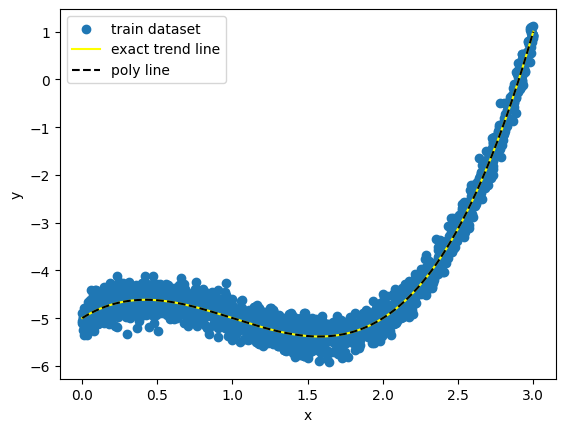

In [29]:
x_min = 0
x_max = 3
N_points = 2000
# Случайный набор X-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), np.array([[-5, 2, -3, 1]])), '--', color='black')
plt.legend(['train dataset', 'exact trend line', 'poly line'])
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('plots/dataset_plot.png')
plt.show

Функция ошибки:

In [30]:
def loss_func(X, y, w_coeff):
    return np.sum((y - f_poly(X, w_coeff))**2)

Функция поиска параметров методом градиентного спуска.

In [ ]:
def model_fit(X_train, y_train, learning_rate, tolerance, batch_ratio, beta):
    t_init = time.time()

    batch_size = int(batch_ratio * len(X_train))
    
    iteration_max = 200000
    
    # Коэффициенты (веса) инициилизируются нулями.
    w_coeff = np.zeros((1,len(learning_rate)))
    # Буфер коэффициентов.
    w_coeff_buff = copy.deepcopy(w_coeff)
    
    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    # Аккумулятор для фильтра градиента.
    grad_filter = np.zeros_like(grad)
    
    losses = []
    
    for i in range(iteration_max):
        for k, w in enumerate(w_coeff.tolist()[0]):
            # Накопление "момента".
            grad_filter[0,k] = beta * grad_filter[0,k] + (1 - beta) * grad[0,k]
            # Шаг градиентного спуска.
            w_step = - learning_rate[k] * grad_filter[0,k]
            # Сбрасываем коэффициенты до необновленных значений.
            w_coeff_1 = copy.deepcopy(w_coeff)
            w_coeff_2 = copy.deepcopy(w_coeff)
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Выборка случайных элементов (по индексам).
            batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_train_batch = [X_train[idx] for idx in batch_indices]
            y_train_batch = [y_train[idx] for idx in batch_indices]
            
            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_func(X_train_batch, y_train_batch, w_coeff  ),
                              loss_func(X_train_batch, y_train_batch, w_coeff_1),
                              loss_func(X_train_batch, y_train_batch, w_coeff_2)]
            # Массив градиента состоит из 3х чисел с индексами [0, 1, 2]. Берем предпоследнее число.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление одного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k]
        # Обновление всех коэффициентов.
        w_coeff = copy.deepcopy(w_coeff_buff)
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)
        
        if i % 100 == 0:
            #print('\x1b[2K', end='')  # Очистить строку
            clear_output(wait=True)
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('Loss:', np.round(loss,4))
        if (loss < tolerance):
            break
    iter_final = i
    fit_time = time.time() - t_init
    return w_coeff, losses, iter_final, fit_time

В ходе обучения заложим среднеквадратическое отклонение до 0.2. Соответствующая сумма квадратов отклонений: (0.2**2 * N_points)=80.

Сначала попробуем обучение на полном датасете, причем learning rate зададим одинаковыми для каждого искомого параметра модели.

Установлено, что большое значение параметра learning rate приводит к неустойчивости решателя. Функция ошибки "улетает" в бесконечность.

Напротив, при малом значении параметра learning rate оптимизация выполняется медленно.

В результате проб подобрано наибольшее значение learning rate, при котором сходимость устойчива (функция ошибки не "улетает" в бесконечность).

In [32]:
# Обучение на полном датасете.
# lr - const.
weights_1, losses_1, iter_final_1, fit_time_1 = model_fit(X_train, y_train,
                                                          learning_rate=5*[1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 1900
Gradient: [ 3943.8777  1467.8529   411.5195   -15.9331 -2687.6957]
Weights: [-1.3021 -0.9574 -0.8986 -0.6409  0.3956]
Loss: 5651.9913


В заданное максимальное число итераций не достигнут желаемый уровень ошибки.

Попробуем задать разный learning rate для параметров модели.

In [33]:
# Обучение на полном датасете.
# lr - индивидуальный для каждого из параметров модели.
weights_2, losses_2, iter_final_2, fit_time_2 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 900
Gradient: [   -28.6441    366.7832     54.1271  -2805.0979 -10503.08  ]
Weights: [-5.1044 -0.3284  0.1273  0.0748  0.0283]
Loss: 742.8744


KeyboardInterrupt: 

В заданное максимальное число итераций также не достигнут желаемый уровень ошибки. Но скорость сходимости улучшилась значительно.

Попробуем обучать не на полном датасете, а на случайно выбранных значениях.

В таком случае оказалось, что обучение на батчах устойчиво при бОльших значениях learning rate. Получается, разбиение на батчи не только снижает объем вычислений, но и позволяет улучшить сходимость за счет большего learning rate.

In [ ]:
# Обучение на случайных батчак, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
weights_3, losses_3, iter_final_3, fit_time_3 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.0)

Iteration: 0
Gradient: [ 1639.6891  2135.7205  3786.9637  7360.9314 15840.172 ]
Weights: [-0.001  -0.0001 -0.     -0.     -0.    ]
MSE loss: 40427.5608
Iteration: 100
Gradient: [  -22.8278   -49.941   -187.1791    27.9543 -2555.2576]
Weights: [-5.092  -0.357   0.1177  0.0761  0.0293]
MSE loss: 719.4556
Iteration: 200
Gradient: [  -17.7646    55.9927    57.1689  -126.6707 -2144.7199]
Weights: [-4.8595 -0.6474  0.1039  0.0893  0.0388]
MSE loss: 487.5871
Iteration: 300
Gradient: [ -22.2885   44.0813   -4.3774 -293.5782  -22.9731]
Weights: [-4.6588 -0.8482  0.0831  0.1     0.0457]
MSE loss: 362.1784
Iteration: 400
Gradient: [   8.6767   65.6788  107.0816   65.8841 -618.6707]
Weights: [-4.4662 -1.024   0.0766  0.1066  0.0508]
MSE loss: 294.3935
Iteration: 500
Gradient: [  17.4356   -6.5911   35.3054   -1.6997 -523.3908]
Weights: [-4.3972 -1.1312  0.0662  0.1103  0.0553]
MSE loss: 256.2042
Iteration: 600
Gradient: [  18.9748   10.5005   22.4872  112.2367 -191.0203]
Weights: [-4.322  -1.188  

Теперь добавим фильтр градиента (momentum) по правилу:

${G_n = \beta G_{n-1} + (1 - \beta)grad_n}$,

${\beta \neq 0}$.

In [ ]:
# Обучение на случайных батчак, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
# Фильтрация градиента (beta=0.8).
weights_4, losses_4, iter_final_4, fit_time_4 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.8)

Iteration: 0
Gradient: [ 1714.0968  2277.851   3558.2021  6944.1239 16172.2552]
Weights: [-0.0002 -0.     -0.     -0.     -0.    ]
MSE loss: 40443.2783
Iteration: 100
Gradient: [   -7.2258    48.9271   150.0499  -475.7346 -1407.051 ]
Weights: [-5.0947 -0.4183  0.1412  0.0772  0.0297]
MSE loss: 694.0009
Iteration: 200
Gradient: [    6.6423    38.3626    65.9427  -214.7784 -1483.1315]
Weights: [-4.7759 -0.7562  0.1249  0.095   0.0385]
MSE loss: 453.1484
Iteration: 300
Gradient: [ -10.5842  -23.9014  -33.8848 -106.9348 -327.2692]
Weights: [-4.5824 -0.9639  0.1046  0.1034  0.0455]
MSE loss: 340.3573
Iteration: 400
Gradient: [ -6.1023   8.7034  86.6525  68.1228 -32.1214]
Weights: [-4.4527 -1.0765  0.0882  0.1115  0.0504]
MSE loss: 287.4852
Iteration: 500
Gradient: [ -11.7672   -7.5045   14.4699 -195.2733 -319.293 ]
Weights: [-4.3761 -1.1716  0.0678  0.1156  0.0548]
MSE loss: 252.1347
Iteration: 600
Gradient: [  -0.8032  -17.0094  -54.1181 -209.217    46.6926]
Weights: [-4.3043 -1.2422  0.05

In [ ]:
weights_5, losses_5, iter_final_5, fit_time_5 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.4)

Iteration: 0
Gradient: [ 1663.9761  2233.8379  4251.7216  8800.175  16958.556 ]
Weights: [-0.0006 -0.0001 -0.     -0.     -0.    ]
MSE loss: 40435.4191
Iteration: 100
Gradient: [   -7.053     19.3734    62.9229   271.7812 -1904.7665]
Weights: [-5.0785 -0.3719  0.1135  0.0759  0.0316]
MSE loss: 685.352
Iteration: 200
Gradient: [    4.2012    46.7002    11.3447    40.217  -1543.2498]
Weights: [-4.7718 -0.7012  0.0979  0.0941  0.0407]
MSE loss: 447.3195
Iteration: 300
Gradient: [ 10.1334   5.4908  65.8489  62.4328 418.5031]
Weights: [-4.614  -0.9031  0.071   0.1062  0.0479]
MSE loss: 329.7207
Iteration: 400
Gradient: [  13.4966   49.4242   37.0195  220.8005 -320.4087]
Weights: [-4.4296 -1.0499  0.0541  0.1127  0.0524]
MSE loss: 275.3564
Iteration: 500
Gradient: [-15.8935  20.5579 -12.2773 154.665  319.5088]
Weights: [-4.3733 -1.1449  0.0459  0.1171  0.0558]
MSE loss: 247.1443
Iteration: 600
Gradient: [ -17.9932  -13.091   -49.5344  -85.9726 -194.5252]
Weights: [-4.3289 -1.2006  0.0348  0.

In [ ]:
weights_6, losses_6, iter_final_6, fit_time_6 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.2,
                                                          beta=0.2)

Iteration: 0
Gradient: [ 3276.3593  4449.2347  7700.183  14530.9014 32023.0087]
Weights: [-0.0008 -0.0001 -0.     -0.     -0.    ]
MSE loss: 40431.4898
Iteration: 100
Gradient: [   -8.4616     7.7936   240.8192  -319.9867 -1193.3659]
Weights: [-4.7874 -0.7348  0.1149  0.0848  0.042 ]
MSE loss: 444.2081
Iteration: 200
Gradient: [ -15.0197    5.1756   51.9554  102.8173 -549.894 ]
Weights: [-4.5304 -0.9762  0.0758  0.1001  0.0524]
MSE loss: 298.4307
Iteration: 300
Gradient: [ -11.845    13.5649   57.2902 -102.8141 -569.1688]
Weights: [-4.3721 -1.1449  0.0415  0.1079  0.0598]
MSE loss: 237.6613
Iteration: 400
Gradient: [  1.0888  10.8448 -48.8712 -85.4495 241.408 ]
Weights: [-4.2594 -1.2221  0.0151  0.1121  0.0645]
MSE loss: 217.0077
Iteration: 500
Gradient: [ -13.8854   52.4613   74.6133  351.4121 -162.808 ]
Weights: [-4.2453 -1.2365 -0.0079  0.1147  0.0673]
MSE loss: 208.6468
Iteration: 600
Gradient: [   3.9225   17.4136   91.36    206.6976 -211.803 ]
Weights: [-4.2146 -1.2351 -0.0312  0

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

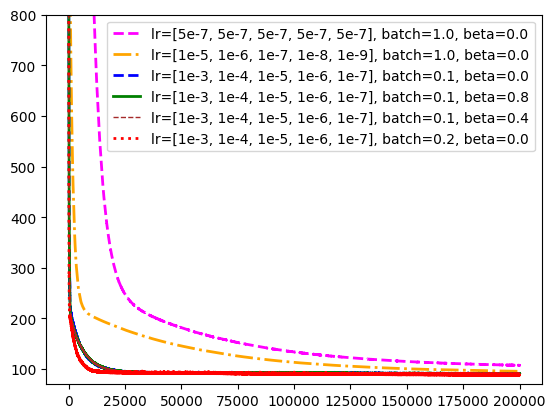

In [ ]:
plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_4, color='green', linestyle='-', linewidth=2)
plt.plot(losses_5, color='brown', linestyle='--', linewidth=1)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,800)
plt.legend(['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
            'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.8',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.4',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show

Кривые для batch=0.1, beta=[0.0, 0.4, 0.8] практически накладываются друг на друга. Следовательно, в рассмотренной частной задачи оптимизации параметр beta незначим. Фильтрация градиента (Momentum) не требуется.

<function matplotlib.pyplot.show(close=None, block=None)>

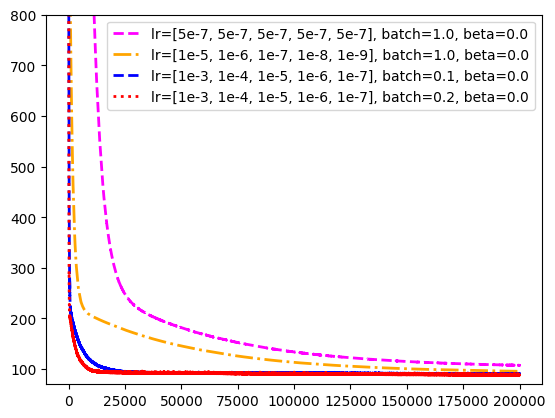

In [ ]:
legend_list =  ['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
                'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0']

plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,800)
plt.legend(legend_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.savefig('plots/MSE_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

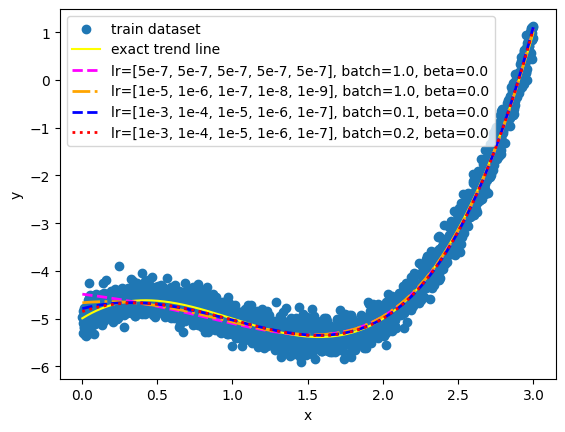

In [ ]:
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_1), color='magenta', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_2), color='orange', linestyle='-.', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_3), color='blue', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_6), color='red', linestyle=':', linewidth=2)
plt.legend(['train dataset', 'exact trend line'] + legend_list)
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('plots/trend_line_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

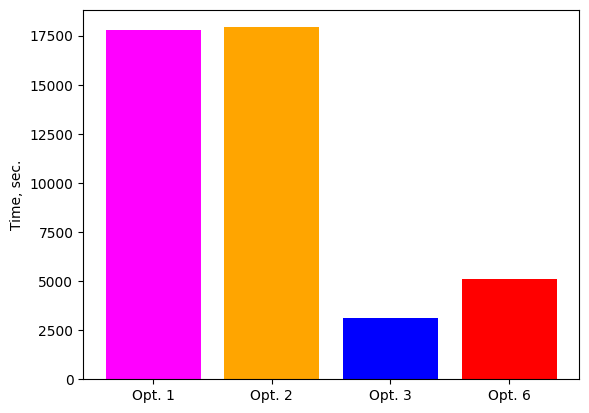

In [ ]:
fit_time = [fit_time_1, fit_time_2, fit_time_3, fit_time_6]
bar_label = ['Opt. 1', 'Opt. 2', 'Opt. 3', 'Opt. 6']
bar_colors = ['magenta', 'orange', 'blue', 'red']
plt.bar(bar_label, fit_time, color=bar_colors)
plt.ylabel('Time, sec.')
#splt.savefig('plots/time_plot.png')
plt.show

In [ ]:
#fit_time = [17800.521367788315, 17925.368300437927, 3114.852860212326, 5091.532459259033]
fit_time

[17800.521367788315, 17925.368300437927, 3114.852860212326, 5091.532459259033]